## NN Adv Assignment

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [27]:
train = pd.read_csv('NN_ADV/Train.csv')
test = pd.read_csv('NN_ADV/Test.csv')

In [28]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
train['label'].nunique()

10

In [33]:
train['label'].value_counts()

2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: label, dtype: int64

In [34]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

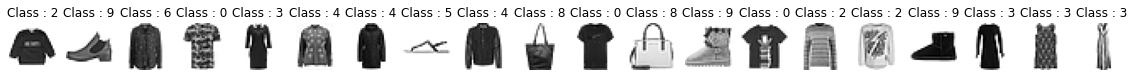

In [36]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [37]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

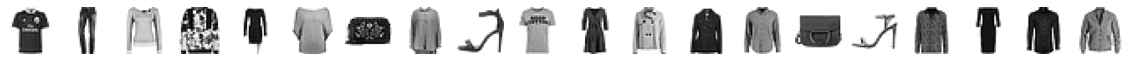

In [38]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [40]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cpu


In [41]:
#Batch Size는 조정 가능합니다.
BATCH_SIZE = 128
#Epoch는 고정해주세요.
EPOCHS = 15

In [42]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
    def __init__(self, image, label = None):
        super(DataSet, self).__init__()
        self._image = image
        self._label = label

    def __len__(self):
        return len(self._image)

    def __getitem__(self, idx):
        if self._label is None:
            image = self._image[idx]
            return image

        else:
            image = self._image[idx]
            label = self._label[idx]
            
            return image, label

In [43]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [44]:
def train(model, train_loader):
    model.train()
    train_loss = 0
    correct = 0

    for image, label in train_loader:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

def pred(model, test_loader):
    model.eval()
    pred_li = []

    with torch.no_grad():
        for image in test_loader:
            image = image.to(DEVICE)
            output = model(image)
            pred_li.append(output.cpu().numpy().argmax(axis=1))

    return np.concatenate(pred_li)

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

In [49]:
class MyNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc1 = nn.Linear(2*2*128, 128, bias=True) 
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        self.linear1 = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            nn.Dropout(p=0.2))
        
        self.fc2 = nn.Linear(128, 64, bias=True) 
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        self.linear2 = nn.Sequential(
            self.fc2,
            nn.ReLU(),
            nn.Dropout(p=0.2)) 
        
        self.fc = nn.Linear(64, 10, bias=True) 
        
    def forward(self, x):
        x = x.reshape(-1, 1, 28, 28)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.reshape(-1, 2*2*128)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.fc(x)
        return x
    
model = MyNet().to(DEVICE)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.0013, 	Train Accuracy: 0.23 %, 	Val Loss: 0.3046, 	Val Accuracy: 88.78 % 

[EPOCH: 2], 	Train Loss: 0.0009, 	Train Accuracy: 0.23 %, 	Val Loss: 0.2652, 	Val Accuracy: 90.43 % 

[EPOCH: 3], 	Train Loss: 0.0007, 	Train Accuracy: 0.24 %, 	Val Loss: 0.2734, 	Val Accuracy: 89.65 % 

[EPOCH: 4], 	Train Loss: 0.0008, 	Train Accuracy: 0.24 %, 	Val Loss: 0.2450, 	Val Accuracy: 91.28 % 

[EPOCH: 5], 	Train Loss: 0.0009, 	Train Accuracy: 0.24 %, 	Val Loss: 0.2447, 	Val Accuracy: 91.53 % 

[EPOCH: 6], 	Train Loss: 0.0004, 	Train Accuracy: 0.25 %, 	Val Loss: 0.2562, 	Val Accuracy: 91.49 % 

[EPOCH: 7], 	Train Loss: 0.0004, 	Train Accuracy: 0.25 %, 	Val Loss: 0.2418, 	Val Accuracy: 91.44 % 

[EPOCH: 8], 	Train Loss: 0.0005, 	Train Accuracy: 0.25 %, 	Val Loss: 0.2322, 	Val Accuracy: 92.17 % 

[EPOCH: 9], 	Train Loss: 0.0006, 	Train Accuracy: 0.24 %, 	Val Loss: 0.2563, 	Val Accuracy: 91.58 % 

[EPOCH: 10], 	Train Loss: 0.0003, 	Train Accuracy: 0.26 %, 	Val Loss: 0.2521, 	Val

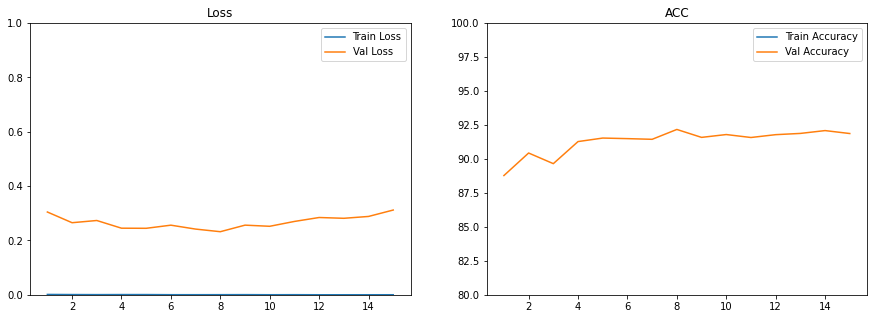

In [50]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()